In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from scipy.sparse import diags
from sklearn.model_selection import train_test_split

def sampleFunctionWithNoise(f, N, sigma, a, b):
    xeval = np.linspace(a, b, N)
    yeval = f(xeval) + rand.normal(scale=sigma, size=N)
    return yeval

def generateTikhonovRegression(yeval, xeval, order, tikMatrix, scaling, type="poly"):
    A = np.ones((len(xeval), order))

    # print(xeval)
    if(type == "poly"):
        for i in range(len(xeval)):
            for j in range(order):
                A[i,j] = xeval[i]**j

    if(type == "trig"):
        for i in range(len(xeval)):
            for j in range(1, order):
                A[i,j] = np.sin(j*xeval[i])
                
    Atranspose = np.transpose(A)
    tikTranspose = np.transpose(tikMatrix)
    
    AtA = np.matmul(Atranspose, A)
    DtD = np.matmul(tikTranspose, tikMatrix)
    C = np.linalg.inv(AtA + scaling * DtD)
    Atb = np.matmul(Atranspose, yeval)
    regressionCoeff =  np.matmul(C, Atb)
    return regressionCoeff


def evalPolyRegression(xeval, coeff):
    y = np.zeros(len(xeval))
    for i in range(len(coeff)):
        orderTerm = xeval**i * coeff[i]
        y += orderTerm
    return y

def evalSinRegression(xeval, coeff):
    y = coeff[0]
    for i in range(1, len(coeff)):
        orderTerm = coeff[i]*np.sin(i* xeval)
        y += orderTerm
    return y

def generateLeastSquares(yeval, xeval, order):
    A = np.ones((len(xeval), order))

    # print(xeval)
    for i in range(len(xeval)):
        for j in range(order):
            # print(i, j)
            A[i,j] = xeval[i]**j 
    
    Atranspose = np.transpose(A)
    regressionCoeff = np.matmul(np.linalg.inv(np.matmul(Atranspose, A)), np.matmul(Atranspose, yeval))
    return regressionCoeff


/tmp/ipykernel_126/3786122213.py:38: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(x_train_poly, y_train_poly)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e+02, tolerance: 3.428e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


18.072144288577153 37.14829659318637 1.0040080160320641
22.80049617761757 22.77779386043274 22.663160224466967
22.874192863160307
OLS error from original function:  30.81348097085195
Ridge error from original function:  28.54166697492249
Tikhonov error from original function:  28.661563996159305
Lasso error from original function:  30.7697625604168


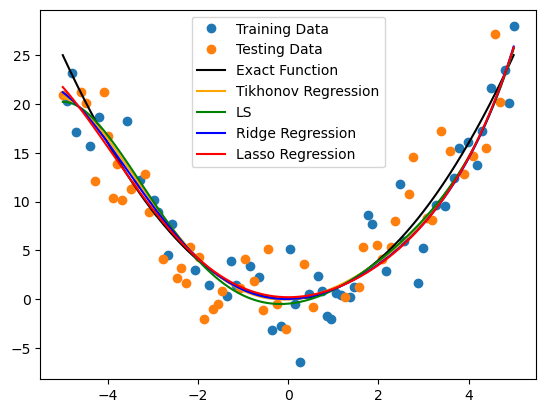

In [2]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(81)

#fpoly = lambda x: np.sin(x) + np.sin(5*x)
fpoly = lambda x: x**2
a = -5
b = 5
N = 100
sigma = 3
order = 6

xeval = np.linspace(a,b,N)
yeval = sampleFunctionWithNoise(fpoly, N, sigma, a, b)
x_train, x_test, y_train, y_test = train_test_split(xeval, yeval, test_size=0.5, random_state=42)

D = diags([-0.5, 0, 0.5], [0, 1, 2], shape=(order , order)).toarray()

xsample = np.linspace(a,b,1000)
trueFunction = fpoly(xsample)
lambdas = np.linspace(0,501,500)
errors_tik = []
errors_ridge = []
errors_lasso = []

poly_features = PolynomialFeatures(degree=5)
x_poly = poly_features.fit_transform(xeval.reshape(-1, 1))

x_train_poly, x_test_poly, y_train_poly, y_test_poly = train_test_split(x_poly, yeval, test_size=0.5, random_state=42)

for i in lambdas:
    ridge = Ridge(alpha=i)
    ridge.fit(x_train_poly, y_train_poly)
    coeff_ridge = list(ridge.coef_)
    lasso = Lasso(alpha=i)
    lasso.fit(x_train_poly, y_train_poly)
    coeff_lasso = list(lasso.coef_)
    coeff = generateTikhonovRegression(y_train, x_train, order, D, i, type="poly")
    modelY = evalPolyRegression(x_test, coeff)
    err = np.linalg.norm(modelY - y_test)
    errors_tik.append(err)
    modelY = evalPolyRegression(x_test, coeff_ridge)
    err = np.linalg.norm(modelY - y_test)
    errors_ridge.append(err)
    modelY = evalPolyRegression(x_test, coeff_lasso)
    err = np.linalg.norm(modelY - y_test)
    errors_lasso.append(err)

optLambda_tik = lambdas[np.argmin(errors_tik)]
optLambda_ridge = lambdas[np.argmin(errors_ridge)]
optLambda_lasso = lambdas[np.argmin(errors_lasso)]
print(optLambda_tik,optLambda_ridge,optLambda_lasso)

print(np.min(errors_tik),np.min(errors_ridge),np.min(errors_lasso))
coeffLS = generateTikhonovRegression(y_train, x_train, order, D, 0, type="poly")
modelY = evalPolyRegression(x_test, coeffLS)
errorLS = np.linalg.norm(modelY - y_test)
print(errorLS)

coeff = generateTikhonovRegression(y_train, x_train, order, D, optLambda_tik, type="poly")

poly_features = PolynomialFeatures(degree=5)
x_poly_sample = poly_features.fit_transform(xsample.reshape(-1, 1))

# Ridge regression
ridge = Ridge(alpha=optLambda_ridge)
ridge.fit(x_train_poly, y_train_poly)
coeffRidge = ridge.coef_
y_pred_ridge = ridge.predict(x_poly_sample)

# Lasso regression
lasso = Lasso(alpha=optLambda_lasso)
lasso.fit(x_train_poly, y_train_poly)
coeffLasso = lasso.coef_
y_pred_lasso = lasso.predict(x_poly_sample)

plt.figure(1)
plt.plot(x_train, y_train, "o", label="Training Data")
plt.plot(x_test, y_test, "o", label="Testing Data")
plt.plot(xsample,fpoly(xsample), label="Exact Function",color='black')
plt.plot(xsample, evalPolyRegression(xsample, coeff), label="Tikhonov Regression",color='orange')
plt.plot(xsample, evalPolyRegression(xsample, coeffLS), label="LS",color='green')
plt.plot(xsample, y_pred_ridge, label='Ridge Regression', color='blue')
plt.plot(xsample, y_pred_lasso, label='Lasso Regression', color='red')
plt.legend()

#errLS = abs(y_test - evalPolyRegression(x_test, coeffLS)) 
errLS = abs(fpoly(xsample) - evalPolyRegression(xsample, coeffLS))
#errTLS = abs(y_test - evalPolyRegression(x_test, coeff))    
errTLS = abs(fpoly(xsample) - evalPolyRegression(xsample, coeff))
coeff_ridge = list(ridge.coef_)
errRidge = abs(fpoly(xsample) - evalPolyRegression(xsample, coeff_ridge))
coeff_lasso = list(lasso.coef_)
errLasso = abs(fpoly(xsample) - evalPolyRegression(xsample, coeff_lasso))


TLSerrNorm = np.linalg.norm(errTLS)
LSerrNorm = np.linalg.norm(errLS)
RidgeerrNorm = np.linalg.norm(errRidge)
LassoerrNorm = np.linalg.norm(errLasso)
print("OLS error from original function: ",LSerrNorm)
print("Ridge error from original function: ",RidgeerrNorm)
print("Tikhonov error from original function: ",TLSerrNorm)
print("Lasso error from original function: ",LassoerrNorm)

# plt.figure(2)
# plt.plot(xsample, errTLS, "o", label="TLS")
# # plt.plot(xsample, f(xsample), "o",label="test set")
# plt.plot(xsample, errLS,  "o",label="LS")
# plt.legend()

plt.show()

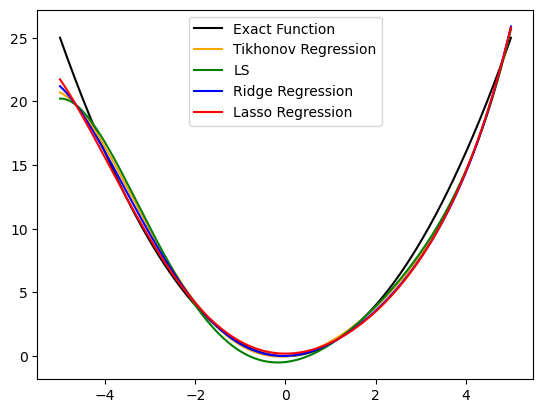

In [24]:
plt.figure(1)
plt.plot(xsample,fpoly(xsample), label="Exact Function",color='black')
plt.plot(xsample, evalPolyRegression(xsample, coeff), label="Tikhonov Regression",color='orange')
plt.plot(xsample, evalPolyRegression(xsample, coeffLS), label="LS",color='green')
plt.plot(xsample, y_pred_ridge, label='Ridge Regression', color='blue')
plt.plot(xsample, y_pred_lasso, label='Lasso Regression', color='red')
plt.legend()

In [25]:
y_pred_ridge = ridge.predict(x_test_poly)
y_pred_lasso = lasso.predict(x_test_poly)
r2_lasso = r2_score(y_test_poly, y_pred_lasso)
print("R^2 score on test set for LASSO regression:", r2_lasso)
r2_ridge = r2_score(y_test_poly, y_pred_ridge)
print("R^2 score on test set for ridge regression:", r2_ridge)
r2_tik = r2_score(y_test, evalPolyRegression(x_test, coeff))
print("R^2 score on test set for Tikhonov regression:", r2_tik)
r2_ols = r2_score(y_test, evalPolyRegression(x_test, coeffLS))
print("R^2 score on test set for OLS regression:", r2_ols)

R^2 score on test set for LASSO regression: 0.8137745099473556
R^2 score on test set for ridge regression: 0.8104161525892777
R^2 score on test set for Tikhonov regression: 0.8099991534375897
R^2 score on test set for OLS regression: 0.8087689115913466


In [27]:
print(coeff)
print(coeffLS)
print(coeffRidge)
print(coeffLasso)
print(ridge.intercept_)
print(lasso.intercept_)

[-0.0199083   0.23816646  1.03105832 -0.10130958 -0.00403963  0.00447996]
[-0.46062445  0.40336745  1.1350177  -0.12786021 -0.00795244  0.00534072]
[ 0.          0.10449786  0.96691392 -0.0786215  -0.00104401  0.00372763]
[ 0.         -0.          0.90058086 -0.05199722  0.00167889  0.0027283 ]
0.01916759235094112
0.19860343691699267
